In [1]:
from helpers import *
warnings.filterwarnings("ignore")

/home/ziaee/anaconda3/envs/vbm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 2
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
subfolder = "0"
path = "../output"
n_sim = 200

In [4]:
os.makedirs(join(path, subfolder, "figs"), exist_ok=True)

In [5]:
SC = load_SC_88("../data")
limb_idx = load_limbic_indices_88("../data")
nn = num_nodes = SC.shape[0]
SC = SC.T

params = {
    "G": 0.5,                         # global coupling strength
    "fix_seed": 0,
    "seed": SEED,
    "t_initial": 0.0,               # initial time * 10[ms]
    "t_transition": 10.0,         # transition time * 10 [ms]
    "t_final": 25000.0,             # end time * 10 [ms]
    "adj": SC,                     # weighted connection matrix
    "data_path": "../output",
    "control": ["G"],
}


In [6]:
prior_min = [0.0]
prior_max = [1.1]

prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min),
    high=torch.as_tensor(prior_max))
prior, _, _ = process_prior(prior)

theta = brute_sample(prior, n_sim, n_sim, 1, 1)
torch.save(theta, join(path, "theta.pt"))
torch.save(prior, join(path, "prior.pt"))


In [7]:
sol = MPR(params)
bold = sol.simulate(theta[1])
if bold.ndim==2:
    labels, stat_vec = get_features(bold)
    print(labels)

['fch', 'fc_sum', 'fcd_sum', 'fluidity']


In [8]:
theta, x = batch_simulator(theta, params, 10)

  2%|▎         | 5/200 [01:50<41:22, 12.73s/it]   

In [ ]:
theta.shape, x.shape

(torch.Size([117, 1]), torch.Size([117, 4]))

In [ ]:
np.savez(join(path, "data.npz"), x=x, theta=theta)

In [ ]:
fc_sum = x[:, labels.index("fc_sum")].numpy()
fcd_sum = x[:, labels.index("fcd_sum")].numpy()
flu = x[:, labels.index("fluidity")].numpy()

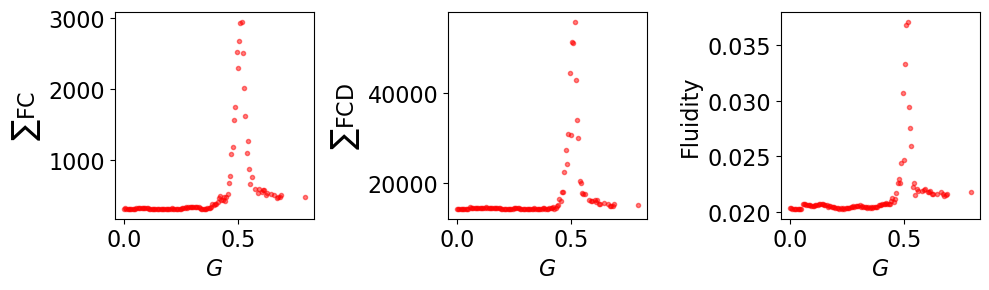

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].plot(theta, fc_sum, "r.", alpha=0.5)
ax[1].plot(theta, fcd_sum, "r.", alpha=0.5);
ax[2].plot(theta, flu, "r.", alpha=0.5);
ylabels = [r"$\sum \mathrm{FC}$", r"$\sum \mathrm{FCD}$", r"Fluidity"]
for i in range(3):
    ax[i].set_xlabel(r"$G$")
    ax[i].set_ylabel(ylabels[i])
plt.tight_layout()
plt.savefig(join(path, subfolder, "figs", "fc_fcd_flu_vs_G.png"), dpi=300)

In [ ]:
posterior = train(prior, theta, x, n_threads=4)

 Neural network successfully converged after 161 epochs.

In [ ]:
with open(join(path, f"posterior.pickle"), "wb") as cf:
    pickle.dump({"posterior": posterior}, cf)
# posterior = pickle.load(open(join(path, "posterior.pickle"), "rb"))["posterior"]

In [ ]:
sub = 1
theta_obs = [0.5]
_, x_obs, bold = wrapper_simulate(0, params, theta_obs, to_file=False)

if bold.ndim == 2:
    np.savez(join(path, subfolder, f"obs_{sub}.npz"), bold=bold, theta=theta_obs, x_obs=x_obs)
    print(f"obs_{sub}.npz Saved")

obs_1.npz Saved


In [ ]:
samples = posterior.sample((10_000,), x=x_obs)
torch.save(samples, join(path, 'samples.pt'))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

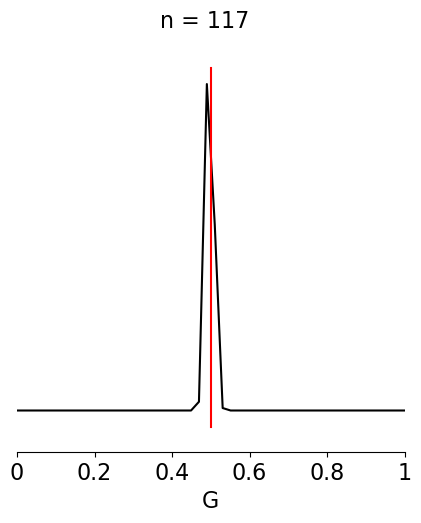

In [ ]:
fig, ax = pairplot(
    samples,
    points=theta_obs,
    figsize=(5, 5),
    limits=[[0, 1]],
    labels=["G"],
    upper='kde',
    diag='kde',
    title=f"n = {len(theta)}",
    points_colors="r",
    samples_colors="k",
    points_offdiag={'markersize': 10})
